In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gfapy
from math import floor
from itertools import product
from dimod.reference.samplers import SimulatedAnnealingSampler
from dimod import BinaryQuadraticModel, BQM
from dwave.system import LeapHybridSampler

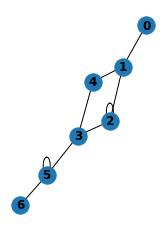

In [2]:
g = nx.Graph()
g.add_nodes_from([
    (0, {"weight": 1}),
    (1, {"weight": 2}),
    (2, {"weight": 3}),
    (3, {"weight": 2}),
    (4, {"weight": 1}),
    (5, {"weight": 4}),
    (6, {"weight": 1})
])
g.add_edges_from([
    (0, 1),
    (1, 2),
    (1, 4),
    (2, 2),
    (2, 3),
    (3, 4),
    (3, 5),
    (5, 5),
    (5, 6)
])
subax1 = plt.subplot(121)
nx.draw(g, with_labels=True, font_weight='bold')

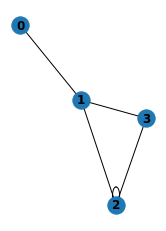

In [52]:
g = nx.Graph()
g.add_nodes_from([
    (0, {"weight": 1}),
    (1, {"weight": 1}),
    (2, {"weight": 2}),
    (3, {"weight": 1}),
])
g.add_edges_from([
    (0, 1),
    (1, 2),
    (2, 3),
    (2, 2),
    (1, 3)
])
subax1 = plt.subplot(121)
nx.draw(g, with_labels=True, font_weight='bold')

In [4]:
def expand_graph_to_max_path_digraph(graph: nx.Graph, final_node=None):
    dg = nx.DiGraph()
    for node in graph.nodes:
        weight = graph.nodes.data()[node]["weight"]
        for k in range(weight):
            dg.add_node(f'{node}_{k}')
        
    for edge in graph.edges:
        if not edge[0] == edge[1]:
            weight_i = graph.nodes.data()[edge[0]]["weight"]
            weight_j = graph.nodes.data()[edge[1]]["weight"]
            for i in range(weight_i):
                for j in range(weight_j):
                    dg.add_edges_from([
                        (f'{edge[0]}_{i}', f'{edge[1]}_{j}'),
                        (f'{edge[1]}_{j}', f'{edge[0]}_{i}')
                    ])
        else:
            weight = graph.nodes.data()[edge[0]]["weight"]
            for i in range(weight - 1):
                dg.add_edge(
                    f'{edge[0]}_{i}', f'{edge[0]}_{i + 1}'
                )
        
    dg.add_node('end')
    if final_node is None:
        final_node = list(g.nodes)[-1]
    weight = graph.nodes.data()[final_node]["weight"]
    for i in range(weight):
        dg.add_edge(f'{final_node}_{i}', 'end')     
    dg.add_edge('end', 'end')        
    
    return dg
    

In [6]:
def max_path_qubo_from_digraph(dg: nx.DiGraph, penalty=None):
    nodes = list(dg.nodes)
    end_node = nodes[-1]
    W = len(nodes) - 1
    if penalty is None:
        penalty = W
    
    qubo_matrix = np.zeros(shape=(W+1, W+1, W+1, W+1), dtype=int)
    for t in range(W):
        for i, j in product(range(W+1), range(W+1)):
            if (nodes[i], nodes[j]) not in dg.edges:
                qubo_matrix[t, i, t+1, j] += penalty
            else:
                qubo_matrix[t, i, t+1, j] += -1 if (nodes[i] != end_node and nodes[j] != end_node) else 0
    
    for t in range(W+1):
        for i in range(W+1):
            qubo_matrix[t, i, t, i] -= penalty
            for j in range(i+1, W+1):
                qubo_matrix[t, i, t, j] += 2 * penalty
                
    for i in range(W+1):
        for t1 in range(W+1):
            qubo_matrix[t1, i, t1, i] -= penalty
            for t2 in range(t1+1, W+1):
                qubo_matrix[t1, i, t2, i] += 2 * penalty
    
    qubo_matrix[1, 1, 1, 1] -= penalty
    qubo_matrix[W, W, W, W] -= penalty
    
    qubo_matrix = qubo_matrix.reshape(((W+1)**2, (W+1)**2))
    
    return qubo_matrix
        
    

In [60]:
dg = expand_graph_to_max_path_digraph(g)    
W = len(dg.nodes) - 1
Q = max_path_qubo_from_digraph(dg, penalty=W)

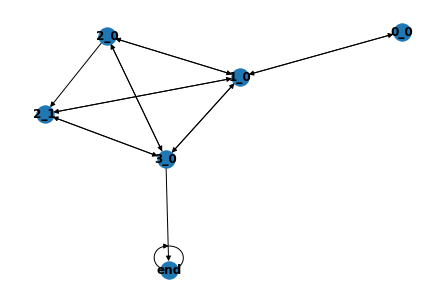

In [59]:
nx.draw_kamada_kawai(dg, with_labels=True, font_weight='bold')

In [61]:
sampler = SimulatedAnnealingSampler()
bqm = BQM(Q, 'BINARY')
bqm.offset = W * (2 * W + 4)

In [62]:
sampleset = sampler.sample(bqm, num_reads=5)
best_sample = sampleset.first.sample
best_energy = sampleset.first.energy

In [10]:
def index_to_node_time(idx, nodes):
    rem = idx % nodes
    div = floor(idx / nodes)
    return (div, rem)

In [64]:
on = []
for i in range(len(best_sample.keys())):
    if best_sample[i] == 1:
        on.append(i)
path = [index_to_node_time(x, W + 1) for x in on]
path = [(e[0], list(dg.nodes)[e[1]]) for e in path]
path

[(0, '0_0'), (1, '1_0'), (2, '2_0'), (3, '2_1'), (4, '3_0'), (5, 'end')]